## Домашняя работа 4.

Максимальный балл за задание - 10.

## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week

Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать:

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов:
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [155]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("/Users/efim/Downloads/data.adult.csv")
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html).

В данном датасете пропущенные значения обозначены как "?".

**Задание 1 (0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [156]:
df.replace("?", np.nan, inplace=True)

col_pr = df.columns[df.isna().any()].tolist()
print("Признаки с пропущенными значениями:", col_pr)

df = df.dropna()
print(f"Количество строк после очистки: {len(df)}")
print("\n")
df.info()

Признаки с пропущенными значениями: ['workclass', 'occupation']
Количество строк после очистки: 15347


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15347 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             15347 non-null  int64 
 1   workclass       15347 non-null  object
 2   fnlwgt          15347 non-null  int64 
 3   education       15347 non-null  object
 4   education-num   15347 non-null  int64 
 5   marital-status  15347 non-null  object
 6   occupation      15347 non-null  object
 7   relationship    15347 non-null  object
 8   race            15347 non-null  object
 9   sex             15347 non-null  object
 10  capital-gain    15347 non-null  int64 
 11  capital-loss    15347 non-null  int64 
 12  hours-per-week  15347 non-null  int64 
 13  >50K,<=50K      15347 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.8+ MB


Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем:

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [157]:
y = df[">50K,<=50K"].apply(lambda x: 1 if x == ">50K" else 0)

X = df.drop(columns=[">50K,<=50K"])
num_feat = X.select_dtypes(include=["int64"])

In [158]:
num_feat.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40


## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [SGD Linear Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 - [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Для начала у первых трёх алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)

Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В качестве схемы кросс-валидации используйте 5-fold cv, которую можно задать с помощью класса [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

**Задание 2 (1 балл)** Для каждого из первых трех алгоритмов подберите оптимальные значения указанных гиперпараметров. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра, на котором также отобразите доверительный интервал [m-std, m+std], где m - среднее, std - стандартное отклонение.

In [159]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold

def algoritm(model, params, title):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(model, param_grid=params, cv=kf, scoring="roc_auc", return_train_score=True)
    grid.fit(X_num, y)
    
    mean_scores = grid.cv_results_["mean_test_score"]
    std_scores = grid.cv_results_["std_test_score"]
    param_name = list(params.keys())[0]  
    x = list(params.values())[0]
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, mean_scores, marker="o", label="Mean ROC-AUC")
    plt.fill_between(x, mean_scores - std_scores, mean_scores + std_scores, alpha=0.2, label="Std. Dev.")
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("ROC-AUC")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Параметры {title}: {grid.best_params_}")
    print(f"ROC-AUC {title}: {grid.best_score_}")

    return grid.best_params_, grid.best_score_

# KNN

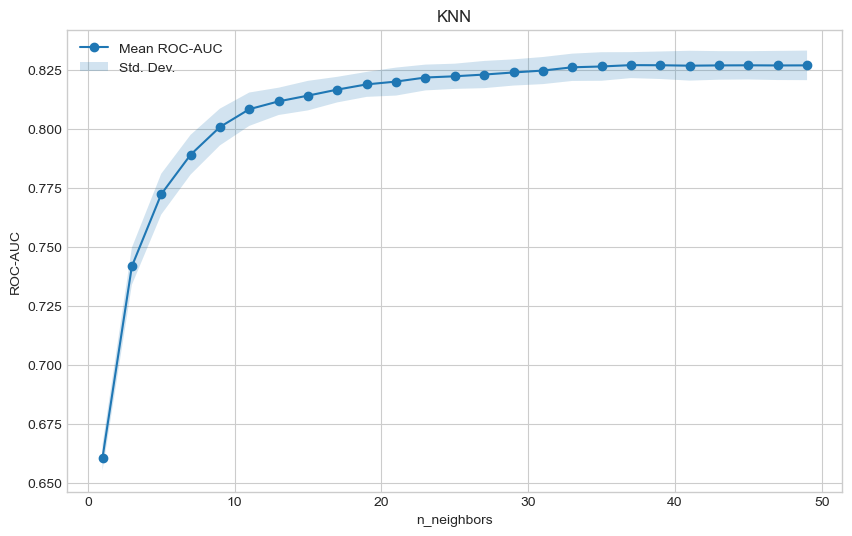

Параметры KNN: {'n_neighbors': 37}
ROC-AUC KNN: 0.8269733432178323


In [166]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
params = {"n_neighbors": np.arange(1, 51, 2)}

algoritm(model, params, "KNN");

KNN показал оптимальное кол-во соседей равное 37. Зависимость качества модели работает как: при малом их значении модель получается слишком гибкая, а при большом слишком обощенная. 

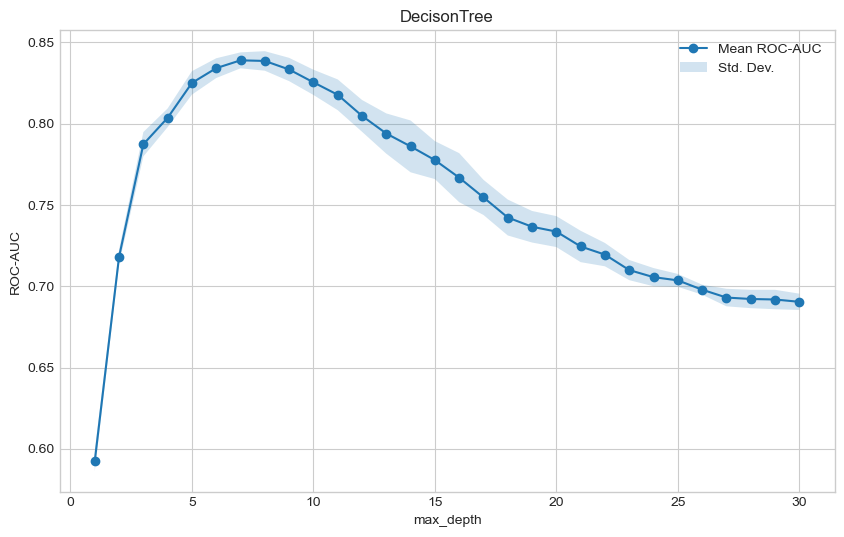

Параметры DecisonTree: {'max_depth': 7}
ROC-AUC DecisonTree: 0.8388992236004036


In [161]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)
params = {"max_depth": np.arange(1, 31, 1)}

algoritm(model, params, "DecisonTree");

Оптимальная глубина модели у десижн три получилась 7, чтобы избежать сильного переобучения

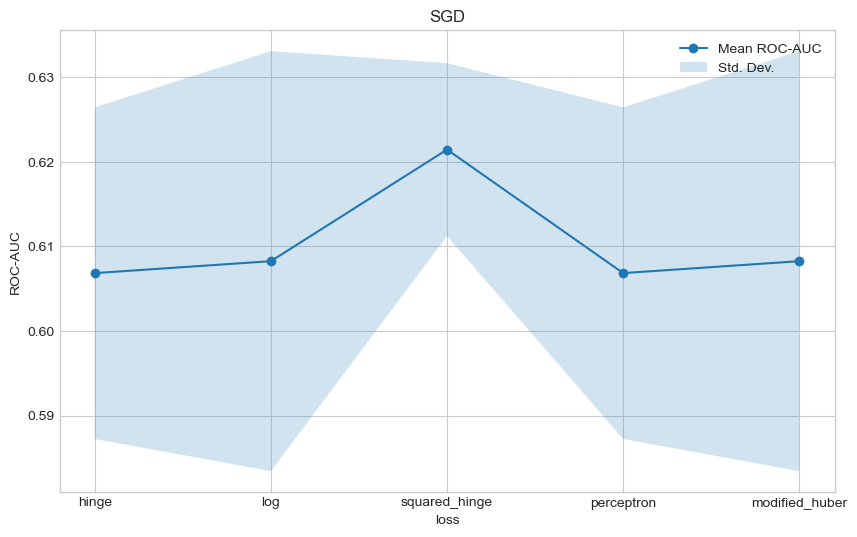

Параметры SGD: {'loss': 'squared_hinge'}
ROC-AUC SGD: 0.6214644578088684


In [126]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(random_state=42)
params = {"loss": ["hinge", "log", "squared_hinge", "perceptron", "modified_huber"]}

algoritm(model, params, "SGD");

Здесь качество модели зависит от выбранной ф-ции потерь, здесь лучше всего себя показал "squared_hinge"

Что вы можете сказать о получившихся графиках? (все описал под графиками)

**Задание 3 (0.5 балла)** Также подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев, так что при увеличении этого гиперпараметра его качество не будет становиться хуже. Поэтому подберите такое количество деревьев, при котором качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества разных размеров, состоящие из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте это количество деревьев.

In [127]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_num, y, test_size = 0.3, random_state=42)

def algoritm_rand(model):
    trees_pr = np.array([estimator.predict(X_test) for estimator in model.estimators_])
    roc_auc_list = [
        roc_auc_score(y_test, trees_pr[:i].mean(axis=0)) 
        for i in range(1, trees_pr.shape[0] + 1)]

    print(f"ROC_AUC: {max(roc_auc_list)}")
    plt.plot(range(1, len(roc_auc_list) + 1), roc_auc_list)
    plt.xlabel("Число деревьев")
    plt.ylabel("ROC_AUC")
    print(f"Оптимальное число деревьев: {roc_auc_list.index(max(roc_auc_list)) + 1}")

ROC_AUC: 0.8156465277994402
Оптимальное число деревьев: 581


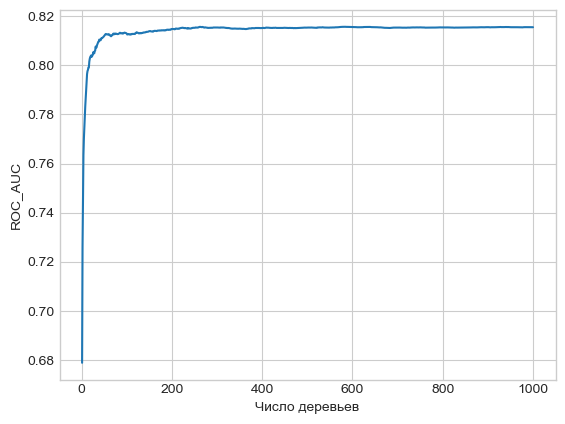

In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

model = RandomForestClassifier(n_estimators = 1000, random_state=42)
model.fit(X_train, y_train)

algoritm_rand(model);

**Задание 4 (0.5 балла)** Подберём число деревьев (*n_estimators*) в алгоритме GradientBoosting. Мы знаем, что ошибка бустинга на тестовых данных, как правило, имеет U-образную форму, то есть сначала уменьшается, а при достижении некоторого числа деревьев начинает расти. Нарисуйте график ошибки в зависимости от числа деревьев. Подберите n_estimators, соответствующий минимуму ошибки.

In [129]:
def algoritm_grad(model):
    trees_pr = np.array([estimator[0].predict(X_test) for estimator in model.estimators_])
    roc_auc_list = [
        roc_auc_score(y_test, trees_pr[:i].mean(axis=0)) 
        for i in range(1, trees_pr.shape[0] + 1)]

    print(f"ROC_AUC: {max(roc_auc_list)}")
    plt.plot(range(1, len(roc_auc_list) + 1), roc_auc_list)
    plt.xlabel("Число деревьев")
    plt.ylabel("ROC_AUC")
    print(f"Оптимальное число деревьев: {roc_auc_list.index(max(roc_auc_list)) + 1}")

ROC_AUC: 0.8608340797582921
Оптимальное число деревьев: 262


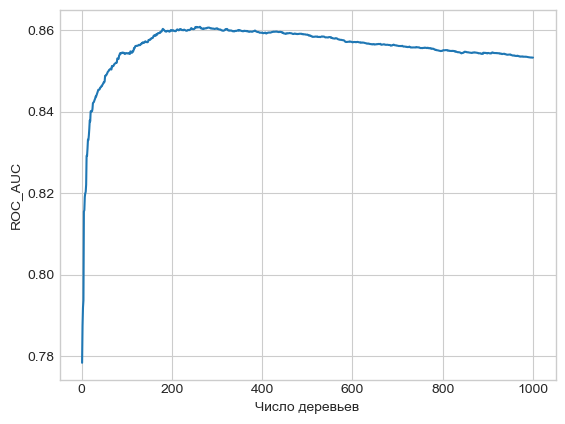

In [130]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators = 1000, random_state=42)
model.fit(X_train, y_train)

algoritm_grad(model)

При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**Задание 5 (0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масштабирование повлиять на работу этих алгоритмов?

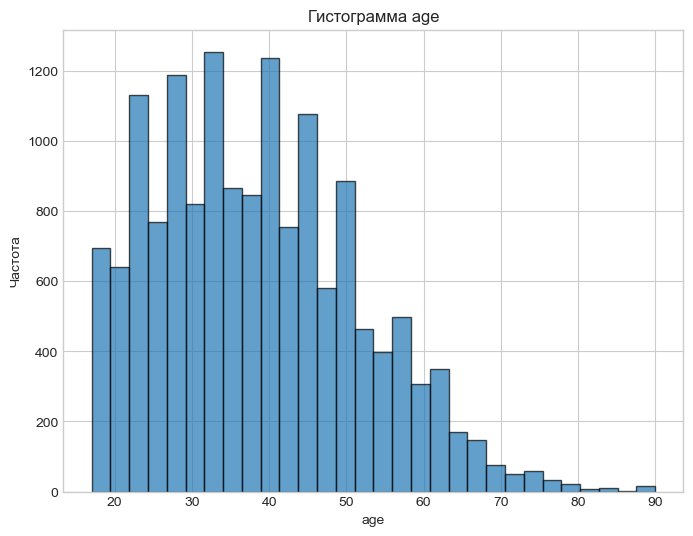

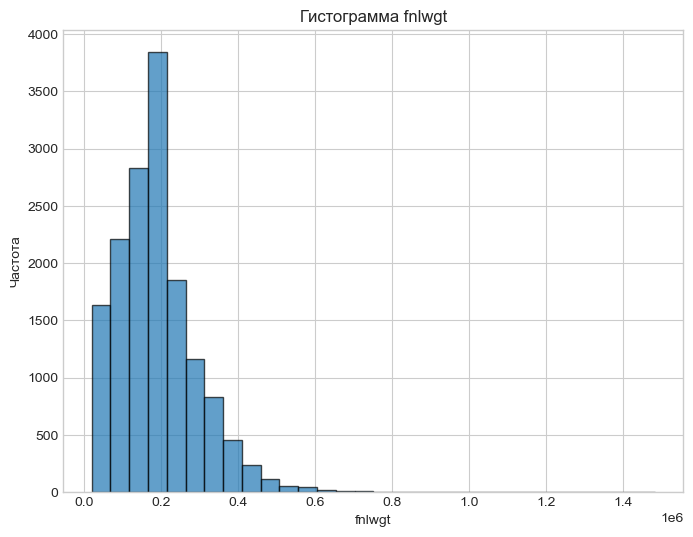

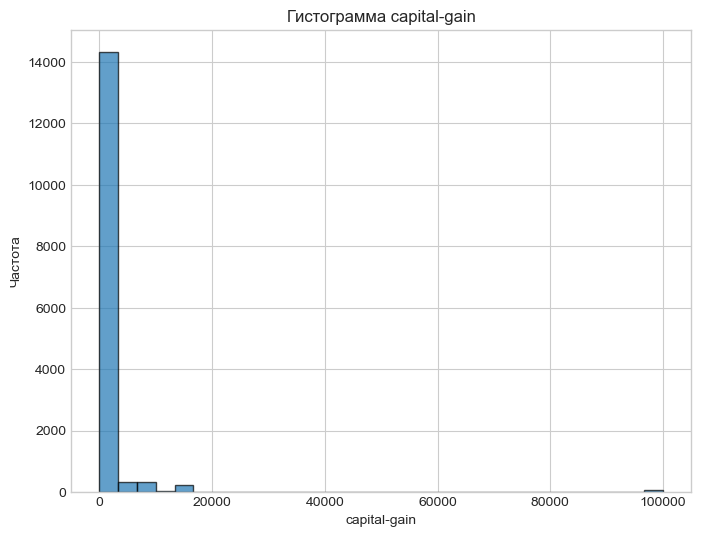

In [131]:
name = ["age", "fnlwgt", "capital-gain"]

for i in name:
    plt.figure(figsize=(8, 6))
    plt.hist(df[i], bins=30, edgecolor="k", alpha=0.7)
    plt.title(f"Гистограмма {i}")
    plt.xlabel(i)
    plt.ylabel("Частота")
    plt.grid(True)
    plt.show()

Данные: их масштаб в каждом случае абсолютно разный. Также у age и fnlwgt мы видим в целом нормальное распределение, а вот у capital-gain оно сильно выделяется слева, сосздавая ассиметрию, что говорит что показатель сильно несбалансирован. Масштабирование: выброс со значением около 10-14к может быть проигнорирован моделями, что усложняет это самое масштабирование. 

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).

**Задание 6 (1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

In [167]:
X_min = X_num.min()
X_max = X_num.max()

num_feat = (num_feat - X_min) / (X_max - X_min)

In [168]:
num_feat.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34.0,284843.0,9.0,594.0,0.0,60.0
1,40.0,190290.0,10.0,0.0,0.0,40.0
2,36.0,177858.0,13.0,0.0,0.0,40.0
3,22.0,184756.0,10.0,0.0,0.0,30.0
4,47.0,149700.0,13.0,15024.0,0.0,40.0


In [169]:
def algoritm2(model, params):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(model, param_grid=params, cv=kf, scoring="roc_auc", return_train_score=True)
    grid.fit(X_num, y)
    
    print(f"ROC_AUC: {grid.best_score_}")
    print(grid.best_params_)

# KNN

In [170]:
model = KNeighborsClassifier()
params = {"n_neighbors": np.arange(1, 51, 2)}

algoritm2(model, params)

ROC_AUC: 0.8269733432178323
{'n_neighbors': 37}


# Decsision tree

In [164]:
model = DecisionTreeClassifier(random_state=42)
params = {"max_depth":  np.arange(1, 31, 1)}

algoritm2(model, params)

ROC_AUC: 0.8388992236004036
{'max_depth': 7}


# SGD Linear Classifier

In [138]:
model = SGDClassifier(random_state=42)
params = {"loss": ["hinge", "log", "squared_hinge", "perceptron", "modified_huber"]}

algoritm2(model, params)

ROC_AUC: 0.8239567583400067
{'loss': 'modified_huber'}


# RandomForest

ROC_AUC: 0.8153240672658864
Оптимальное число деревьев: 261


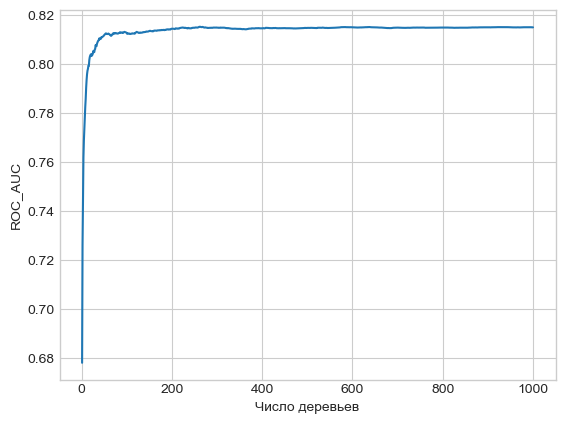

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X_num, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators = 1000, random_state=42)
model.fit(X_train, y_train)

algoritm_rand(model)

# GradientBoosting

ROC_AUC: 0.8607173502829978
Оптимальное число деревьев: 254


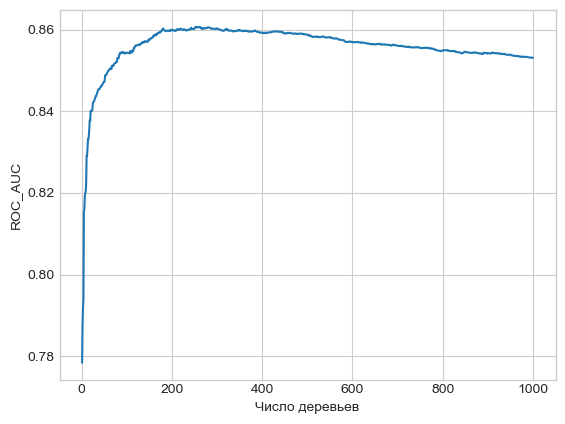

In [140]:
model = GradientBoostingClassifier(n_estimators = 1000, random_state=42)
model.fit(X_train, y_train)

algoritm_grad(model)

Изменилось ли качество у некоторых алгоритмов?

Масштабирование сыграло определенную роль на изменение ROC AUC:

До масштабирования:

1) KNN: 0.8269733432178323
2) Decison Tree: 0.8388992236004036
3) Gradient Boosting (SGDClassifier): 0.6214644578088684
4) RandomForest: 0.8156465277994402
5) GradientBoosting: 0.8608340797582921
    
После масштабирования:

1) KNN: 0.8269733432178323
2) Decison Tree: 0.8388992236004036
3) Gradient Boosting (SGDClassifier): 0.8239567583400067
4) RandomForest: 0.8153240672658864
5) GradientBoosting: 0.8607173502829978

Качество Gradient Boosting (SGDClassifier), значительно выросло, но все остальное практически не поменялось;

**Задание 7 (1.25 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае:
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - GradientBoosting — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*

Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели"

In [141]:
models = {"kNN": KNeighborsClassifier(),
          "Tree": DecisionTreeClassifier(random_state=42),
          "SGD": SGDClassifier(random_state=42),
          "Forest": RandomForestClassifier(max_features=928, random_state=42),
          "Boosting": GradientBoostingClassifier(max_features=254, random_state=42)}

params = {"kNN": {"n_neighbors": np.arange(1, 10, 1), 
                 "metric": ["cityblock", "cosine", "euclidean", "haversine", 
                            "l1", "l2", "manhattan", "nan_euclidean", "minkowski"]},
          "Tree": {"max_depth": np.arange(1, 15, 1),
                  "criterion": ["gini", "entropy", "log_loss"]},
          "SGD": {"loss": ["hinge", "log", "squared_hinge", "perceptron", "modified_huber"],
                  "penalty": ["l2", "l1", "elasticnet", None]},
          "Forest": {"criterion": ["gini", "entropy", "log_loss"]},
          "Boosting": {"loss": ["log_loss", "exponential"]}}


results = []
for name, model in models.items():
    kf = KFold(n_splits=5)
    grid = GridSearchCV(estimator=model, param_grid=params[name], cv=kf, scoring="roc_auc", n_jobs=-1)
    grid.fit(X_num, y)
    results.append((name, grid.best_params_, grid.best_score_))

for result in results:
    print(f"Model: {result[0]} | Best Params: {result[1]} | Best Score: {result[2]}")

python(77759) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77760) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77761) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77762) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77763) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77764) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77765) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77766) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77767) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77768) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/efim/anaconda

Model: kNN | Best Params: {'metric': 'cityblock', 'n_neighbors': 9} | Best Score: 0.8029895957260035
Model: Tree | Best Params: {'criterion': 'entropy', 'max_depth': 8} | Best Score: 0.841289133969975
Model: SGD | Best Params: {'loss': 'log', 'penalty': 'l1'} | Best Score: 0.8249597319068448
Model: Forest | Best Params: {'criterion': 'entropy'} | Best Score: 0.8191718849057148
Model: Boosting | Best Params: {'loss': 'exponential'} | Best Score: 0.862998060330883


Какой из алгоритмов имеет наилучшее качество?

Model: Boosting | Best Params: {'loss': 'exponential'} | Best Score: 0.862998060330883 
Градиентный бустинг имеет лучший результат.

**Задание 8 (0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

# KNN

In [142]:
from tqdm import tqdm
%%time

model = KNeighborsClassifier(n_neighbors=9, metric="cityblock")
model.fit(X_train, y_train)


UsageError: Line magic function `%%time` not found.


# DecisonTree

In [144]:
%%time

model = DecisionTreeClassifier(max_depth=8, criterion="entropy", random_state=42)
model.fit(X_train, y_train)

CPU times: user 32.8 ms, sys: 4.25 ms, total: 37.1 ms
Wall time: 34.8 ms


DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42)

# SGD Linear Classifier

In [145]:
%%time

model = SGDClassifier(loss="log", penalty="l1", random_state=42)
model.fit(X_train, y_train)

CPU times: user 28.2 ms, sys: 10.2 ms, total: 38.3 ms
Wall time: 37 ms


SGDClassifier(loss='log', penalty='l1', random_state=42)

# RandomForest

In [146]:
%%time

model = RandomForestClassifier(n_estimators = 928, criterion="entropy", random_state=42)
model.fit(X_train, y_train)

CPU times: user 6.93 s, sys: 122 ms, total: 7.05 s
Wall time: 7.06 s


RandomForestClassifier(criterion='entropy', n_estimators=928, random_state=42)

# GradientBoosting

In [147]:
%%time
model = GradientBoostingClassifier(n_estimators = 254, loss="exponential", random_state=42)
model.fit(X_train, y_train)

CPU times: user 1.46 s, sys: 18.3 ms, total: 1.48 s
Wall time: 1.47 s


GradientBoostingClassifier(loss='exponential', n_estimators=254,
                           random_state=42)

Дольше всего работает RandomForest (total: 7.05 s), вызвано это тем, что:

Построение очень большого количества деревьев требует много времени, entropy очень сложный для расчетов, так как использует большие для вычисления логарифмы

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков.

**Задание 9 (0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [148]:
from sklearn.preprocessing import OneHotEncoder
X_cat = X.select_dtypes(exclude=["int64"])
encoder = OneHotEncoder(drop="first", sparse=False)
ohe_features = encoder.fit_transform(X_cat)
ohe_df = pd.DataFrame(ohe_features, index=X.index, columns=encoder.get_feature_names_out())

X_all = pd.concat([X_num.reset_index(drop=True), ohe_df.reset_index(drop=True)], axis=1)
X_all.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,0.232877,0.181207,0.533333,0.005940,0.0,0.602041,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.315068,0.116683,0.600000,0.000000,0.0,0.397959,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.260274,0.108200,0.800000,0.000000,0.0,0.397959,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.068493,0.112907,0.600000,0.000000,0.0,0.295918,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.410959,0.088984,0.800000,0.150242,0.0,0.397959,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


**Задание 10 (0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [171]:
from sklearn.model_selection import cross_val_score
models = {
    "KNN": KNeighborsClassifier(n_neighbors=9, metric="cityblock"),
    "Tree": DecisionTreeClassifier(max_depth=8, criterion="entropy", random_state=42),
    "SGD": SGDClassifier(loss="log", penalty="l1", random_state=42),
    "Forest": RandomForestClassifier(n_estimators=928, criterion="entropy", random_state=42),
    "Boosting": GradientBoostingClassifier(n_estimators=254, loss="exponential", random_state=42)}

for name, model in models.items():
    score = cross_val_score(model, X_all, y, cv=5, scoring="roc_auc").mean()
    print(f"Model {name}: {score}")

Model KNN: 0.8571461084777177
Model Tree: 0.8908047073795504
Model SGD: 0.9016618817531457
Model Forest: 0.9036530806897227
Model Boosting: 0.9237281309557727


Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

Да, качество вырасло еще больше: 

**Результаты:**
1) GradientBoosting после перебора: 0.862998060330883
2) GradientBoosting после добавления признаков: 0.9237281309557727

## Поиск новых полезных признаков

**Задание 11 (1.25 балла).** Попробуем улучшить качество модели, добавив в неё новые информативные признаки. Поступим так же, как действовали на [семинаре](https://github.com/Murcha1990/ML_Econom_2021-2022/blob/main/Семинары/Семинар%207/Seminar7.ipynb):
* добавьте к модели полиномиальных признаков степени 2 (для создания полиномиальных признаков используйте только исходные числовые признаки)
* затем снизьте размерность с помощью:
a) фильтрационных методов
b) жадного отбора признаков (RFE)
с) встроенного в модель метода отбора признаков.

Для каждого пункта выше выберите один метод и подберите для него оптимальные гиперпараметры, а также количество финальных признаков (по кросс-валидации).

* Затем можно добавить к модели закодированные в предыдущем пункте категориальные признаки.

Позволил ли этот подход улучшить качество моделей?

In [151]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif

kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_num)

selector = SelectKBest(score_func=f_classif, k=20)
X_reduced = selector.fit_transform(X_poly, y)
X_final = np.hstack([X_reduced, X_all])

for name, model in models.items():
    scores = cross_val_score(model, X_final, y, cv=kf, scoring="roc_auc", n_jobs=-1)
    results.append({
        "Model": name,
        "ROC-AUC": np.mean(scores)})
    
results_df = pd.DataFrame(results)
print(results_df)

python(78283) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(78284) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(78285) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(78286) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(78287) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(78288) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(78289) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(78290) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/efim/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` whic

      Model   ROC-AUC
0       kNN  0.865920
1      Tree  0.888577
2       SGD  0.907425
3    Forest  0.902513
4  Boosting  0.920974


**10 пункт:**
- Model KNN: 0.8571461084777177
- Model Tree: 0.8908047073795504
- Model SGD: 0.9016618817531457
- Model Forest: 0.9036530806897227
- Model Boosting: 0.9237281309557727

**11 пункт:**
- kNN: 0.865920
- Decison Tree: 0.888577
- Gradient Boosting: 0.907425
- RandomForest: 0.902513
- GradientBoosting: 0.920974

Где-то снизилось, где-то выросло. И везде не сильно, прям конкретно что-то сказать нельзя, хотя в целом метод странный. 

## Смешивание моделей

Во всех предыдущих пунктах мы получили много сильных моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и случайный лес). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**Задание 12 (1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

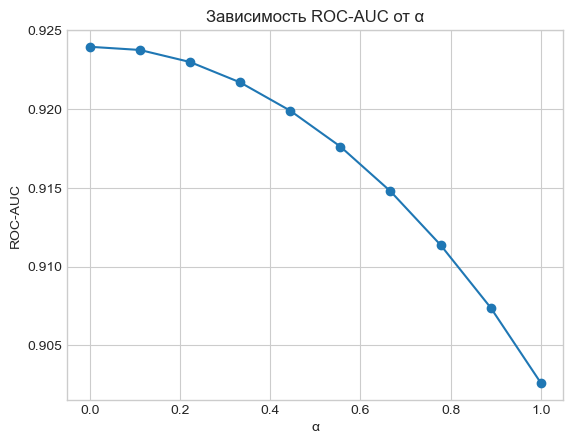

Лучшее значение α: 0.0, Лучший ROC-AUC: 0.9239533420573764


In [153]:
alphas = np.linspace(0, 1, 10) 
kf = KFold(n_splits=5, shuffle=True, random_state=42)
roc_auc_scores = np.zeros(len(alphas))

for train_index, test_index in kf.split(X_all):
    X_train, X_test = X_all.iloc[train_index], X_all.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    clf_1 = RandomForestClassifier(n_estimators=928, criterion="entropy", random_state=42)
    clf_2 = GradientBoostingClassifier(n_estimators=254, loss="exponential", random_state=42)
    clf_1.fit(X_train, y_train)
    clf_2.fit(X_train, y_train)
    prob_1, prob_2 = clf_1.predict_proba(X_test)[:, 1], clf_2.predict_proba(X_test)[:, 1]
    roc_auc_scores += [roc_auc_score(y_test, prob_1 * alpha + prob_2 * (1 - alpha)) for alpha in alphas]

roc_auc_scores /= kf.get_n_splits()

plt.plot(alphas, roc_auc_scores, marker="o")
plt.title("Зависимость ROC-AUC от α")
plt.xlabel("α")
plt.ylabel("ROC-AUC")
plt.grid(True)
plt.show()

best_alpha = alphas[np.argmax(roc_auc_scores)]
print(f"Лучшее значение α: {best_alpha:}, Лучший ROC-AUC: {roc_auc_scores.max():}")

В итоге у альфы лучшее получилось 0.
- GradientBoosting после добавления признаков: 0.9237281309557727
- GradientBoosting в смешанной моделе: 0.9239533420573764

В итоге получаем небольшое улучшение качества модели.

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**Задание 13 (1 балл)** Для каждого типа классификатора (kNN, DecisionTree, RandomForest, SGD classifier), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации (с учетом подобранных гиперпараметров) и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).

Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

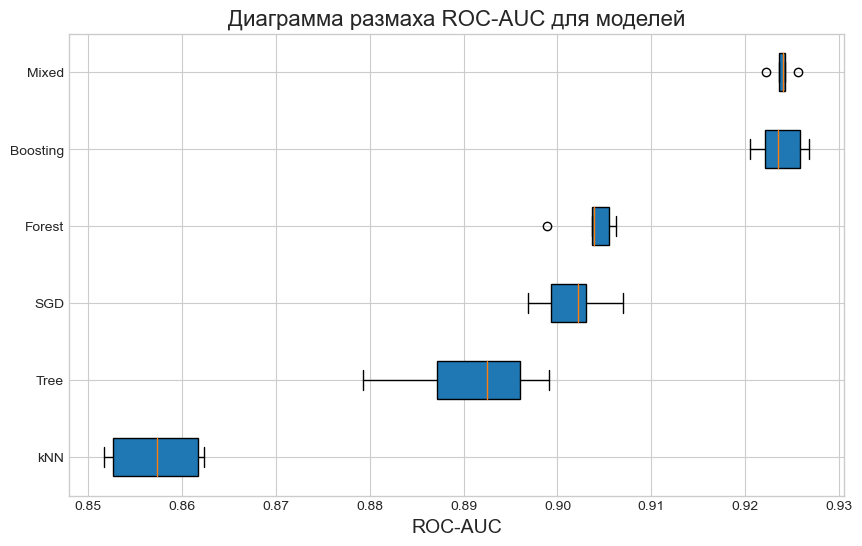

In [154]:
model_scores = {name: cross_val_score(model, X_all, y, cv=5, scoring="roc_auc") for name, model in models.items()}

roc_auc_mixed = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in kf.split(X_all):
    X_train, X_test = X_all.iloc[train_idx], X_all.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    clf_1 = RandomForestClassifier(n_estimators=928, criterion="entropy", random_state=42)
    clf_2 = GradientBoostingClassifier(n_estimators=254, loss="exponential", random_state=42)
    clf_1.fit(X_train, y_train)
    clf_2.fit(X_train, y_train)

    prob_1 = clf_1.predict_proba(X_test)[:, 1]
    prob_2 = clf_2.predict_proba(X_test)[:, 1]
    best_alpha = 0 
    combined_prob = prob_1 * best_alpha + prob_2 * (1 - best_alpha)
    roc_auc_mixed.append(roc_auc_score(y_test, combined_prob))

model_scores["Mixed"] = roc_auc_mixed

plt.figure(figsize=(10, 6))
plt.boxplot(model_scores.values(), vert=False, patch_artist=True, labels=model_scores.keys())
plt.title("Диаграмма размаха ROC-AUC для моделей", fontsize=16)
plt.xlabel("ROC-AUC", fontsize=14)
plt.grid(True)
plt.show()

Итоговый вывод:

- kNN: простая модель, чувствительна к масштабу данных и размерности, обучалась быстро, но в целом достаточно плоха в сравнении с другими.
- DecisionTree: хорошо работает с категориальными, сама модель достаточно простая. Но при этом и часто приходит к переобучению. 
- SGD Linear Classifier: чувтсвительная к функции потерь, но зато быстрая и получаются неплохие результаты.
- Random Forest: отлично работает со сложными задачами, неплохо справляется с переобучением (что порой очень важно), но занимает и больше времени. Особенно когда деревьев очень много.
- Gradient Boosting: самая лучшая модель по результатам, в целом вот и все.